# 使用模式递归重写

In [1]:
from testing import viz_expr # 可视化 relay

In [2]:
import numpy as np
import tvm
from tvm import relay
from tvm.relay.dataflow_pattern import *

构建计算图：

In [3]:
data = relay.var("data", relay.TensorType((2, 8), "float32"))
dense_weight = relay.const(np.zeros((4, 8)))
feat = relay.nn.dense(data, dense_weight)
feat = relay.cast(feat, "float32")
feat = relay.cast(feat, "float32")
feat = relay.cast(feat, "float32")
feat = relay.cast(feat, "float32")
feat = relay.cast(feat, "float32")
oup = relay.cast(feat, "float32")

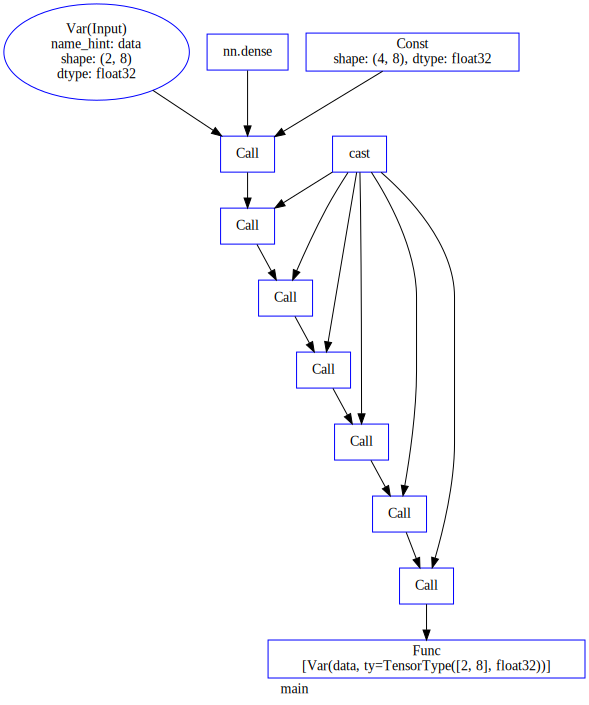

In [4]:
viz_expr(oup)

In [5]:
print(tvm.IRModule.from_expr(oup))

def @main(%data: Tensor[(2, 8), float32]) {
  %0 = nn.dense(%data, meta[relay.Constant][0], units=None);
  %1 = cast(%0, dtype="float32");
  %2 = cast(%1, dtype="float32");
  %3 = cast(%2, dtype="float32");
  %4 = cast(%3, dtype="float32");
  %5 = cast(%4, dtype="float32");
  cast(%5, dtype="float32")
}




构建模式：

In [6]:
class TheRewrite(DFPatternCallback):
    def __init__(self, pattern):
        super().__init__(rewrite_once=True)
        self.pattern = pattern

    def callback(self, pre, post, node_map):
        return relay.nn.relu(post)

In [7]:
expected = relay.nn.relu(oup)

In [8]:
def test_reset_call_args():
    dense_pattern = is_op("nn.dense")(wildcard(), wildcard())
    wildcard_redirect = wildcard()
    the_pattern = is_op("cast")(wildcard_redirect)
    the_pattern2 = the_pattern | dense_pattern
    wildcard_redirect.redirect_to(the_pattern2)

    actual = rewrite(TheRewrite(the_pattern), oup)
    tvm.ir.assert_structural_equal(actual, expected)

def test_reset_alt_left():
    dense_pattern = is_op("nn.dense")(wildcard(), wildcard())
    wildcard_redirect = wildcard()
    or_pattern = wildcard_redirect | dense_pattern
    the_pattern = is_op("cast")(or_pattern)
    wildcard_redirect.redirect_to(the_pattern)

    actual = rewrite(TheRewrite(the_pattern), oup)
    tvm.ir.assert_structural_equal(actual, expected)

def test_reset_alt_right():
    dense_pattern = is_op("nn.dense")(wildcard(), wildcard())
    wildcard_redirect = wildcard()
    or_pattern = dense_pattern | wildcard_redirect
    the_pattern = is_op("cast")(or_pattern)
    wildcard_redirect.redirect_to(the_pattern)

    actual = rewrite(TheRewrite(the_pattern), oup)
    tvm.ir.assert_structural_equal(actual, expected)

test_reset_call_args()
test_reset_alt_left()
test_reset_alt_right()